In [5]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory
from src.models.shapely_test import shap_plot

In [6]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [7]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = (os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))
arctic_df = pd.read_pickle(arctic_pkl)

In [8]:
from pickle import load
import matplotlib.pyplot as plt
import numpy as np
# =============================================================================
# Load in pickle file
# =============================================================================
filename = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/models/XGboost/SIC_xgboostMLD.sav"
# Previous pickle file returned a list so we will perform 
# multiple assignment here
model, X_train, X_test, Y_train, Y_test = load(open(filename, 'rb'))

[13:47:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [9]:
# Get the predicted values
y_pred = model.predict(X_test)

In [10]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

In [11]:
from src.models.encode_features import encode_tulabeldict

arctic_df["Tu_label"] = Tu_label(arctic_df["Tu"])
arctic_df, labels = encode_tulabeldict(arctic_df)
# MLDJ generates better results than MLDI, also according to literature and visual inspectation
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

In [12]:
y_pred_df_SIC = pd.DataFrame(y_pred, columns=ystringlist_all_SIC)
# Rename the 'eps_pred' column to 'log_eps'
y_pred_df_SIC = y_pred_df_SIC.rename(columns={'log_eps': 'eps_pred'})

# Reset index on y_pred_df_SIC and y_test_df_SIC
y_pred_df_SIC.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Create a new dataframe with index column
index_df_SIC = pd.DataFrame({'index': range(len(y_pred_df_SIC))})

SIC_all_testdf = create_testdf(X_test, Y_test, y_pred_df_SIC)
merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=["log_eps", "depth", "latitude"])

#merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all+ystringlist)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
merged_df_SIC["residuals"] = residuals_SIC
merged_df_SIC["abs_residuals"] = np.abs(residuals_SIC)
#stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")
# merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstringlist_all+ystringlist)

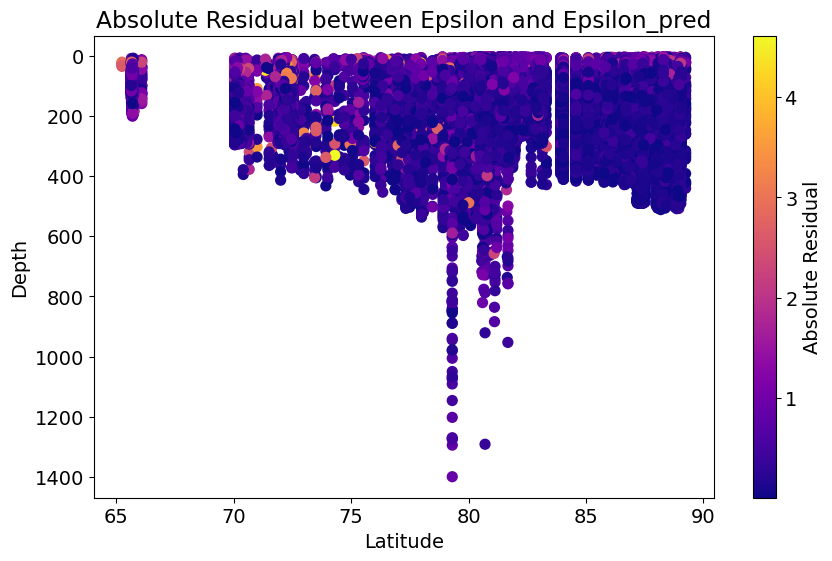

In [15]:
# arctic_all_testdf
plot_residuals(merged_df_SIC)

In [18]:
from scipy import stats
def plot_std_lat(test_df):
    """
    Plots the mean and standard deviation of absolute residuals by latitude.

    Parameters:
        test_df (pd.DataFrame): A dataframe containing the test data features,
        true epsilon values, and predicted epsilon values.

    Returns:
        None

    Example:
        # Assuming test_df is a dataframe with columns 'latitude', 'depth',
        # 'log_eps' (true epsilon values), and 'eps_pred' (predicted epsilon
        # values)
        plot_std_lat(test_df)
    """
    # Calculate the absolute residuals between 'kappa' and 'kappa_pred'
    abs_residual = np.abs(test_df['log_eps'] - test_df['eps_pred'])

    # Define the latitude and absolute residual values
    latitude = test_df['latitude'].values
    abs_residual_values = abs_residual.values

    # Define the binning for latitude
    bin_width = 1.0  # Adjust the bin width as desired
    lat_bins = np.arange(latitude.min(), latitude.max() + bin_width, bin_width)

    # Compute the mean and standard deviation of the absolute residuals
    # for each latitude bin
    mean_resid, bin_edges, _ = stats.binned_statistic(latitude,
                                                      abs_residual_values,
                                                      statistic='mean',
                                                      bins=lat_bins)
    std_resid, _, _ = stats.binned_statistic(latitude, abs_residual_values,
                                             statistic='std', bins=lat_bins)

    # Compute the bin centers for plotting
    lat_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # Create a line plot of the mean and standard deviation
    plt.figure(figsize=(10, 6))
    plt.plot(lat_centers, mean_resid, marker='o', label='Mean', color='blue')
    plt.plot(lat_centers, std_resid, marker='o', label='Standard Deviation',
             color='orange')

    # Add labels and title
    plt.xlabel('Latitude ($\degree$)')
    plt.ylabel('Absolute Residual')
    plt.title('Mean and Standard Deviation of Absolute Residual by Latitude')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

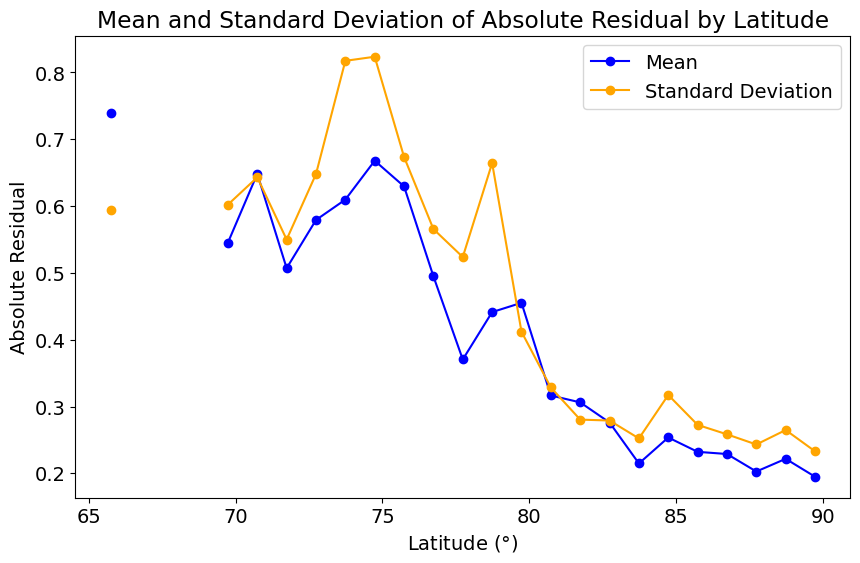

In [19]:
plot_std_lat(merged_df_SIC)

In [2]:
def plot_residuals(test_df):
    """
    Plots the absolute residuals between the true and predicted epsilon value
    as a scatter plot, limited to the top 300 meters.

    Parameters:
        test_df (pd.DataFrame): A dataframe containing the test data features,
        true epsilon values, and predicted epsilon values.

    Returns:
        None

    Example:
        # Assuming test_df is a dataframe with columns 'latitude', 'depth',
        # 'log_eps' (true epsilon values), and 'eps_pred'
        plot_residuals(test_df)
    """
    abs_residual = np.abs(test_df['log_eps'] - test_df['eps_pred'])

    # Limit the dataframe to the top 300 meters
    limited_df = test_df[test_df['depth'] <= 500]

    # Apply the same filtering to the abs_residual variable
    limited_abs_residual = abs_residual[test_df['depth'] <= 500]

    # Define the x and y coordinates for the scatter plot
    latitude = limited_df['latitude'].values
    depth = limited_df['depth'].values

    # Create a scatter plot of the absolute residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(latitude, depth, c=limited_abs_residual, cmap='plasma', s=50)
    plt.colorbar(label='Absolute Residual')
    plt.xlabel('Latitude')
    plt.ylabel('Depth')
    plt.title('Absolute Residual between Epsilon and Epsilon_pred (Top 300 meters)')

    # Invert the y-axis
    plt.gca().invert_yaxis()

    # Show the plot
    plt.show()


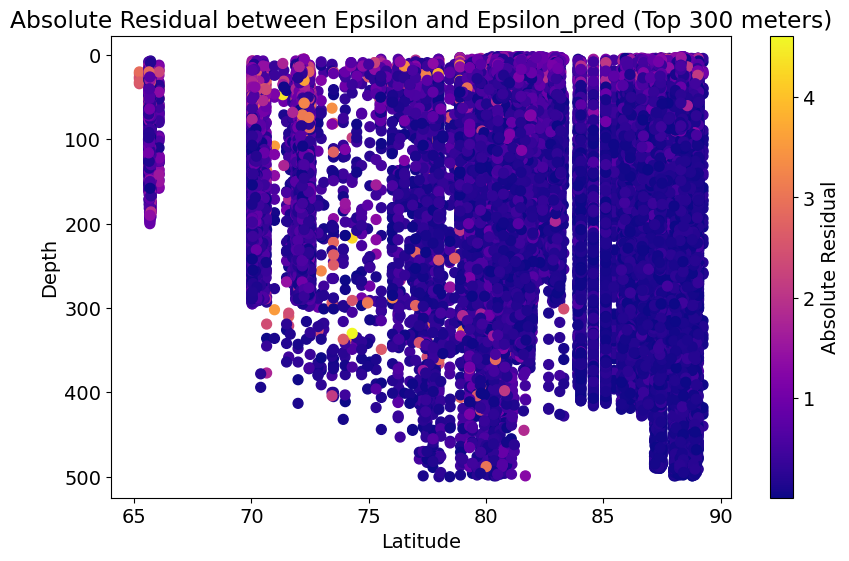

In [20]:
plot_residuals(merged_df_SIC)

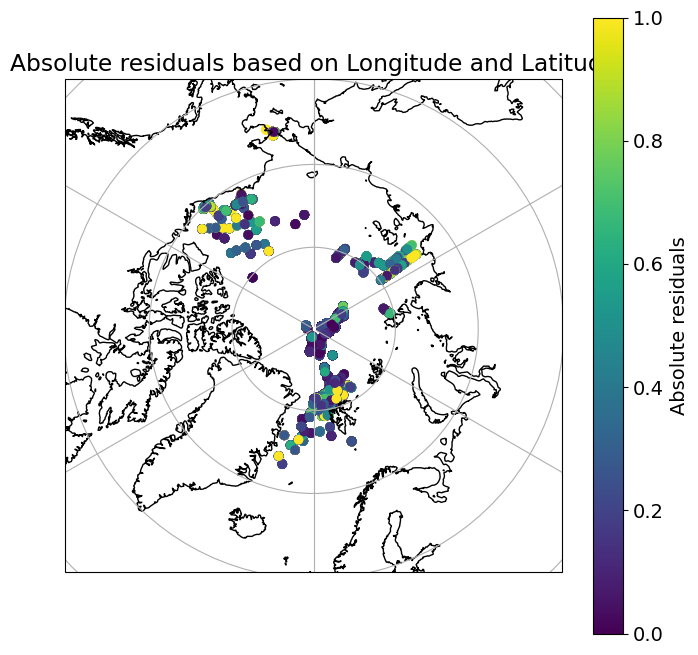

In [14]:
stereo_plot(merged_df_SIC, merged_df_SIC["abs_residuals"], "Absolute residuals", vmin=0, vmax=1)

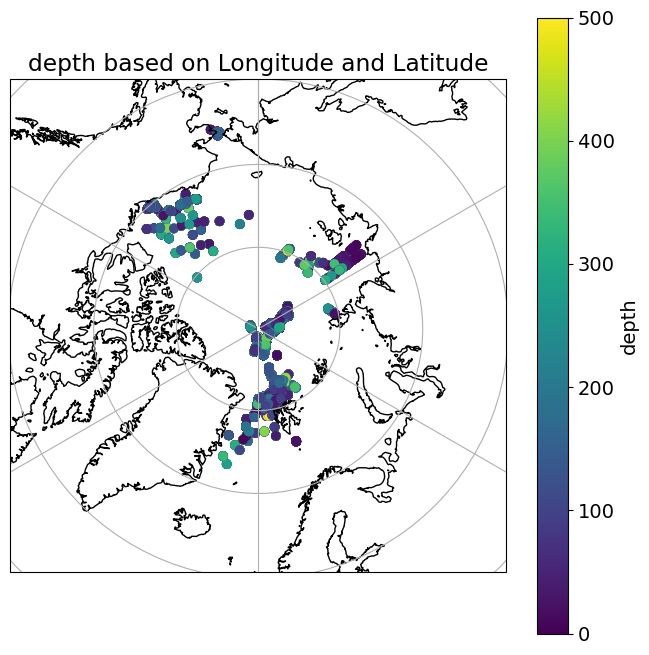

In [25]:
stereo_plot(merged_df_SIC, merged_df_SIC["depth"], "depth", vmin=0, vmax=500)

In [9]:
merged_df_SIC["Tu_label"] = merged_df_SIC["Tu_label_x"]

In [17]:
import pandas as pd

def calc_correlation(merged_df):
    """
    Calculate correlation coefficients between the variables and
    absolute residuals.

    Args:
        merged_df (DataFrame): Merged dataframe containing the relevant
        variables and absolute residuals.

    Returns:
        correlation_matrix (DataFrame): Correlation matrix showing the
        correlation coefficients.

    """
    merged_df["absolute_residuals"] = np.abs(
        merged_df["log_eps"] - merged_df["eps_pred"])
    
    # Select the relevant columns from merged_df
    variables = ['depth', 'latitude', 'longitude', 'Tu_x', 'absolute_residuals']
    data = merged_df[variables]
    
    # Calculate correlation coefficients
    correlation_matrix = data.corr()
    
    # Extract the correlations with absolute residuals
    correlation_with_residuals = correlation_matrix['absolute_residuals'][:-1]
    
    print("Correlation with Absolute Residuals:")
    print(correlation_with_residuals)
    
    return correlation_matrix


In [18]:
calc_correlation(merged_df_SIC)

Correlation with Absolute Residuals:
depth       -0.274023
latitude    -0.316470
longitude   -0.222369
Tu_x         0.086495
Name: absolute_residuals, dtype: float64


,depth,latitude,longitude,Tu_x,absolute_residuals
depth,1.000000,0.066223,-0.017096,0.135201,-0.274023
latitude,0.066223,1.000000,0.741133,-0.123230,-0.316470
longitude,-0.017096,0.741133,1.000000,-0.024145,-0.222369
Tu_x,0.135201,-0.123230,-0.024145,1.000000,0.086495
absolute_residuals,-0.274023,-0.316470,-0.222369,0.086495,1.000000
